In [1]:
pip install pyserial

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3 -> 23.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [12]:
#Librerias
import serial.tools.list_ports
import serial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

In [2]:
# Función que regresa el verdadero valor hexadecimal.
# Por ejemplo, si recibe un 15 devuelve f, y si recibe un número menor a 10, devuelve el número sin modificarlo
def obtener_caracter_hexadecimal(valor):
    # Lo necesitamos como cadena
    valor = str(valor)
    equivalencias = {
        "10": "A",
        "11": "B",
        "12": "C",
        "13": "D",
        "14": "E",
        "15": "F",
    }
    if valor in equivalencias:
        return equivalencias[valor]
    else:
        return valor


def decimal_a_hexadecimal(decimal):
    hexadecimal = ""
    while decimal > 0:
        residuo = decimal % 16
        verdadero_caracter = obtener_caracter_hexadecimal(residuo)
        hexadecimal = verdadero_caracter + hexadecimal
        decimal = int(decimal / 16)
    return hexadecimal

In [3]:
#tipo de movimiento 
def Tipo_de_movimiento(lower_bound, upper_bound):
    while True:
        try:
            number = int(input("Tipo de desplazamiento:Mov absoluto (1) o Mov Relativo (2)"))

            if number == lower_bound:
                tip = str("0ma")
                return tip
            if number == upper_bound:
                tip = str("0mr")
                return tip
        except ValueError:
            pass
        print(f"Por favor ingresa un número ({lower_bound} o {upper_bound})")

In [21]:
def Detección_de_puertos(puertos):
    
    # Obtener una lista de puertos seriales disponibles
    ports = serial.tools.list_ports.comports()
    
    # Imprimir la lista de puertos seriales disponibles
    print("Puertos seriales disponibles:")
    for i, port in enumerate(ports):
        print(f"{i+1}. {port.device}")

    # Permitir al usuario seleccionar un puerto serial
    selected_port = int(input("Seleccione el puerto para el " + puertos))

    # Asignar el puerto serial seleccionado a diferentes funciones
    #Configuración del puerto
    port = serial.Serial(ports[selected_port-1].device,  baudrate=9600, bytesize=8, parity='N', stopbits=1, timeout=None, xonxoff=0, rtscts=0)
    
    #Apertura del puerto

    #port.open()
    a = port.is_open

    #Comprobación del estado del puerto e inicialización

    if a:
        print("El puerto se encuentra abierto" + "\n")

    else:
        print("Puerto no disponible" + "\n")
        
    return port

In [34]:
def Data_prom(ser, num):
    # Creamos una lista vacía
    lista = []

    # Pedimos al usuario que ingrese 10 datos y los agregamos a la lista
    for i in range(num):
        while True:
            dato = ser.readline().decode().strip()
            try:
                valor = float(dato)
                lista.append(valor)
                break
            except:
                print("Ingrese un valor numérico")

    # Calculamos el promedio de los valores en la lista
    if len(lista) > 0:
        promedio = sum(lista) / len(lista)
        print("La lista es:", lista)
        print("El promedio de los valores en la lista es:", promedio)
    else:
        print("La lista está vacía")
    return promedio

In [42]:
def Graficar(name):
    
    df = pd.read_csv(name + ".txt", names=['columna1', 'columna2'])

    # Interpolar los datos
    x = np.array(df['columna1'])
    y = np.array(df['columna2'])

    # Interpolar los datos
    x, y = zip(*sorted(zip(x, y)))
    x_smooth = np.linspace(x[0], x[-1], 200)
    y_smooth = make_interp_spline(x, y, k=3)(x_smooth)

    # Crear gráfico con la curva suavizada
    plt.plot(x_smooth, y_smooth, color='red', label='Curva suavizada')


    #Crear gráfico con la curva no suavizada
    plt.plot(x, y, color='blue', label='Curva no suavizada')


    # Mostrar los puntos originales
    plt.scatter(x, y, color='black', label='datos obtenidos')
    
    #Barras de error

    plt.errorbar(x, y, xerr = 2.51E-03, yerr = 0.05,  fmt = 'o',color = 'black', 
                ecolor = 'black', elinewidth = 0.5, capsize=2)

    # Añadir leyenda
    plt.legend()

    # Agregar etiquetas y título al gráfico
    plt.xlabel('Ángulo de incidencia Θ')
    plt.ylabel('Intensidad')
    plt.title('Curva Obtenida')

    # Mostrar el gráfico
    return plt.show()

In [40]:
#Detección, apertura y comprobación de los puertos:

mot = Detección_de_puertos("Motor :")
ardu = Detección_de_puertos("Arduino :")

#inicialización

com2 = "0ho0"
init2 = com2.encode('utf_8','strict')
mot.write(init2) 

#Leer una línea de respuesta
response = mot.readline() 

# Crear un archivo para guardar los datos

file_name = input("Ingrese el nombre del archivo con el que desea que se guarde :")
file = open(file_name + ".txt","w") 

while True: 
    try:
        #Ingreso del desplazamiento angular
        des = float(input("Ingrese el desplazamiento (entre 0 y 359.99). \nO ingrese 999 para finalizar"))
        if des == 999:
            print("Programa detenido")
            break
        if 0 <= des < 360:

            #Conversión a hexadecimal y codificación
            dec_num = (float(des)*np.pi)/(4.38282*pow(10,-5)*180)
            hexa = decimal_a_hexadecimal(int(dec_num))
            hexa = hexa.zfill(8)

            #tipo de movimiento
            tipo = Tipo_de_movimiento(1,2)
            hexa = str(tipo + hexa)
            #print(hexa)
            str_encoded= hexa.encode('utf_8','strict') 

            # Enviar una cadena de bytes
            mot.write(str_encoded)

            #Verificación del hexadecimal unido
            #str_encoded

            # Leer una línea de respuesta
            response = mot.readline() 
            print("En hexadecimal : ", response.decode())

            # Respuesta y conversión a decimal

            prueba1 = response.decode()
            res_des = int(prueba1[3:11],16)

            #Conversión a decimal a grados de la posión del motor

            save_des = res_des*(4.38282*pow(10,-5)*180)/np.pi

            #Impresión de la posión del motor en grados
            print ("En grados : ","{0:.2f}".format(save_des))       
            
            
            # Leer el segundo dato de la comunicación serial
            dato2 = Data_prom(ardu, 10)
            
            #Impresion datos promedio de fotodiodo
            print ("Promedio intesidad : ", dato2)     
        
            # Escribir los datos en el archivo
            file.write("{0},{1}\n".format(save_des, dato2))

        else:
            print("Por favor ingresa un número válido")
    except ValueError:
        print("Por favor ingresa un número válido")

#Cerrar Archivo

file.close()

#Graficar 

Graficar(file_name)

# Mostrar el gráfico
plt.show()
            
#Cerrar puerto
mot.close()
mot.is_open

ardu.close()
ardu.is_open

Puertos seriales disponibles:
1. COM8
2. COM5
Seleccione el puerto para el Motor :2
El puerto se encuentra abierto

Puertos seriales disponibles:
1. COM8
2. COM5
Seleccione el puerto para el Arduino :1
El puerto se encuentra abierto

Ingrese el desplazamiento (entre 0 y 359.99). 
O ingrese 999 para finalizar60
Tipo de desplazamiento:Mov absoluto (1) o Mov Relativo (2)1
En hexadecimal :  0PO00005D52

En grados :  59.99
Ingrese un valor numérico
La lista es: [5.0, 0.06, 0.05, 0.07, 0.05, 0.05, 0.07, 0.05, 0.05, 0.06]
El promedio de los valores en la lista es: 0.5509999999999999
Promedio intesidad :  0.5509999999999999
Ingrese el desplazamiento (entre 0 y 359.99). 
O ingrese 999 para finalizar90
Tipo de desplazamiento:Mov absoluto (1) o Mov Relativo (2)2
En hexadecimal :  0PO0000E954

En grados :  150.00
La lista es: [0.06, 0.05, 0.06, 0.06, 0.05, 0.05, 0.06, 0.05, 0.05, 0.07]
El promedio de los valores en la lista es: 0.055999999999999994
Promedio intesidad :  0.055999999999999994
Ingres

False

In [38]:
#Cerrar puerto
mot.close()
mot.is_open

ardu.close()
ardu.is_open

False

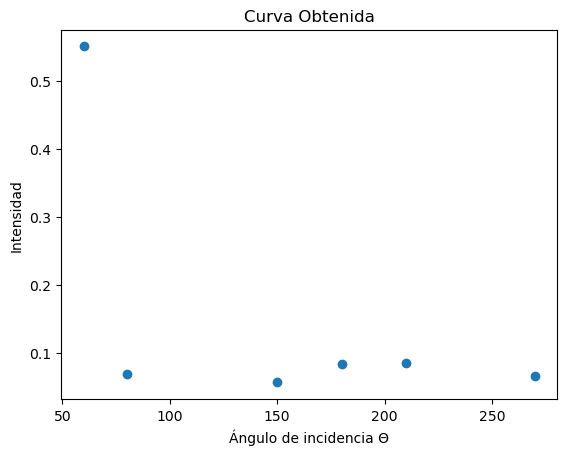

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar datos CSV sin etiquetas
df = pd.read_csv('arc.txt', names=['columna1', 'columna2'])

# Crear gráfico de puntos
plt.plot(df['columna1'], df['columna2'], linestyle='none', marker='o')

# Agregar etiquetas y título al gráfico
plt.xlabel('Ángulo de incidencia Θ')
plt.ylabel('Intensidad')
plt.title('Curva Obtenida')

# Mostrar el gráfico
plt.show()

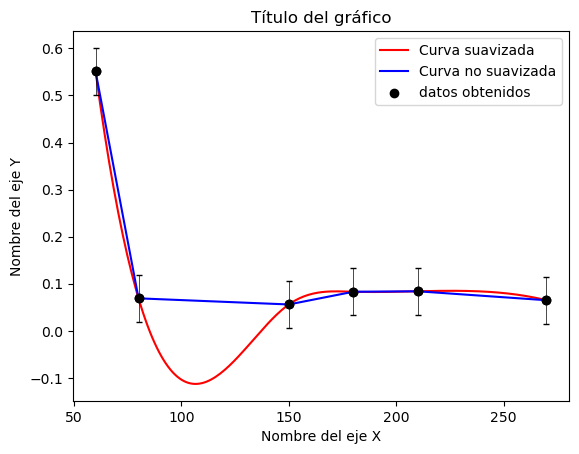

In [70]:
# Cargar datos CSV sin etiquetas
df = pd.read_csv('arc.txt', names=['columna1', 'columna2'])

# Interpolar los datos
x = np.array(df['columna1'])
y = np.array(df['columna2'])

# Interpolar los datos
x, y = zip(*sorted(zip(x, y)))
x_smooth = np.linspace(x[0], x[-1], 200)
y_smooth = make_interp_spline(x, y, k=3)(x_smooth)

# Crear gráfico con la curva suavizada
plt.plot(x_smooth, y_smooth, color='red', label='Curva suavizada')

#Crear gráfico con la curva no suavizada
plt.plot(x, y, color='blue', label='Curva no suavizada')


# Mostrar los puntos originales
plt.scatter(x, y, color='black', label='datos obtenidos')

#Barras de error

plt.errorbar(x, y, xerr = 2.51E-03, yerr = 0.05,  fmt = 'o',color = 'black', 
            ecolor = 'black', elinewidth = 0.5, capsize=2)

# Añadir leyenda
plt.legend()

# Agregar etiquetas y título al gráfico
plt.xlabel('Nombre del eje X')
plt.ylabel('Nombre del eje Y')
plt.title('Título del gráfico')

# Mostrar el gráfico
plt.show()